# CptS 481 - Python Software Construction

## Unit 18: Embedding and Extending Python

In [1]:
# Note: Because this unit involves compilation, some of these steps are Linux-specific.
#    They may or may not work on Windows or MacOS.

try:
    from dot_figure import dotFigure
except:
    print("Unable to import 'dot_figure'. Is it installed?")
    quit()

from IPython.display import HTML
HTML(open("../include/notes.css", "r").read())

### Embedding Python

To "embed" Python means to access Python from within another program, in this case a C program. To do this, the C program has to follow certain rules. For starters:

* ``#include`` the header file ``<Python.h>``

* call ``Py_Initialize()`` before invoking Python.

* call ``Py_Finalize()`` when you're done with the interpreter.

Incidentally, all this works in C++ with appropriate "``extern "C" { ... };``" wrappers, but we'll assume C for the rest of this unit.

#### A Simple Embedding

Here's a simple example:

In [3]:
from time import time, ctime
time()

1542137374.0866394

In [4]:
ctime(time())

'Tue Nov 13 11:30:11 2018'

In [5]:
%%file demos/d0_embed_print_time.c
#include <Python.h>

int
main(int argc, char *argv[])
{
  Py_Initialize();
  PyRun_SimpleString("from time import time, ctime\n"
                     "print('Today is', ctime(time()))\n");
  Py_Finalize();
  return 0;
}

Overwriting demos/d0_embed_print_time.c


``PyRun_SimpleString()`` does what its name suggests: Invokes the Python interpreter on any C string. Let's compile and run this:

In [6]:
%%sh
cd demos
make immaculate # clean up previous make results
make d0_embed_print_time OSNAME=LINUX

rm -rf *~ __pycache__ a.out *.o d4_swig_3funcs.py d4_swig_3funcs_wrap.c
rm -rf d0_embed_print_time d1_embed_call build 
cc -g -Wall -fPIC -Wstrict-prototypes -I/usr/include/python3.6m d0_embed_print_time.c -lpython3.6m -o d0_embed_print_time


Let's look at the compile and link flags:

* "``-g -Wall -Wstrict-prototypes``" -- the usual good choices for C compile flags

* "``-I``*directory*" -- the directory containing "``Python.h``" (the "``3.6m``" suffix will vary with Python version)

* "``-lpython3.6m``" -- the library to use (``/usr/lib/x86_64-linux-gnu/libpython3.6m.so`` on a Linux system). The Python version should be the same as for the "``-I``" flag.

* "``-o d0_embed_print_time``" -- the binary (linked) file

Then we're ready to run the file:

In [7]:
!cd demos; ./d0_embed_print_time

Today is Tue Nov 13 11:35:39 2018


Easy, huh? Part of that is because we're not passing data between Python and C. That makes things a bit more complicated.

#### Passing Data Between C and Python (Embedded Python)

To pass data between your C program and Python requires you to call several Python library function to convert C data to Python data and vice versa. Here's a C function that imports a module and calls any function in it that accepts and returns C doubles.

In [13]:
%%file demos/d1_embed_call.c
#include <stdlib.h>
#include <Python.h>

int
main(int argc, char *argv[])
{
    PyObject *pName, *pModule, *pFunc;
    PyObject *pArgs, *pValue;
    int i;

    if (argc < 3) {
        fprintf(stderr, "Usage: %s moduleName functionName [arg]*\n", argv[0]);
        return 1;
    }

    Py_Initialize();
    pName = PyUnicode_FromString(argv[1]);
    /* Error checking of pName left out */

    pModule = PyImport_Import(pName);
    Py_DECREF(pName);

    if (pModule != NULL) {
        pFunc = PyObject_GetAttrString(pModule, argv[2]);
        /* pFunc is a new reference to the function we want to call. Notice
         * how it's an attribute of the module.*/

        if (pFunc && PyCallable_Check(pFunc)) {
            pArgs = PyTuple_New(argc - 3);
            /* Set up arguments in pArgs */
            for (i = 0; i < argc - 3; ++i) {
                pValue = PyFloat_FromDouble(atof(argv[i + 3]));
                if (!pValue) {
                    Py_DECREF(pArgs);
                    Py_DECREF(pModule);
                    fprintf(stderr, "Cannot convert argument\n");
                    return 1;
                }
                /* pValue reference stolen here: */
                PyTuple_SetItem(pArgs, i, pValue);
            }
            pValue = PyObject_CallObject(pFunc, pArgs);
            Py_DECREF(pArgs);
            if (pValue != NULL) {
                printf("Result of call: %g\n", PyFloat_AsDouble(pValue));
                Py_DECREF(pValue);
            }
            else {
                Py_DECREF(pFunc);
                Py_DECREF(pModule);
                PyErr_Print();
                fprintf(stderr,"Call failed\n");
                return 1;
            }
        }
        else {
            if (PyErr_Occurred())
                PyErr_Print();
            fprintf(stderr, "Cannot find function \"%s\"\n", argv[2]);
        }
        Py_XDECREF(pFunc);
        Py_DECREF(pModule); 
    }
    else {
        PyErr_Print();
        fprintf(stderr, "Failed to load \"%s\"\n", argv[1]);
        return 1;
    }
    Py_Finalize();
    return 0;
}

Overwriting demos/d1_embed_call.c


All Python objects -- modules, functions, scalars, lists, tuples, etc. -- are ``PyObject`` pointers in C, reflecting Python's polymorphism. It's pythonic to use a naming convention to keep track of these classes.

Pay special attention to the ``Py_DECREF()`` macros (that's what they are). When you invoke the Python library from C, you have to maintain reference counts yourself by passing ``PyObject`` pointers to it when they're no longer in use. 
By analogy to C, think of every "``Py*``()" function that returns a "``PyObject *``" (which is most of them) as if it were a ``malloc(3)`` call and treat ``Py_DECREF()`` as if it were a ``free(3)`` call.

Use ``Py_XDECREF()`` if it's possible that the pointer may be ``NULL`` (in which case, the macro does nothing).

In [14]:
%%sh
cd demos
make immaculate
make d1_embed_call OSNAME=LINUX

rm -rf *~ __pycache__ a.out *.o d4_swig_3funcs.py d4_swig_3funcs_wrap.c
rm -rf d0_embed_print_time d1_embed_call build 
cc -g -Wall -fPIC -Wstrict-prototypes -I/usr/include/python3.6m d1_embed_call.c -lpython3.6m -o d1_embed_call


In [16]:
!cd demos; ./d1_embed_call math atan2 1 1

Result of call: 0.785398


In [17]:
!cd demos; ./d1_embed_call math sin 3.14159

Result of call: 2.65359e-06


That's the basics of calling Python from a C program. You can use this to use Python as a *application language*: users write little (usually) Python modules to customize big (usually) non-Python code. *Blender*, the extensive animation package, for instance, uses this.

### Extending Python

Perhaps more useful than embedding Python, invoking Python from another language, is *extending* Python: adding functionality written in another language to Python. This is how, for instance, you can write a Python API for a non-Python library.

#### A Simple Extension

Here's a a simple C extension that we'll turn into a Python module:

In [ ]:
%%file demos/d2_extend_hello.c
#include <Python.h>
#include <stdio.h>

static struct PyModuleDef thisModule = {
   PyModuleDef_HEAD_INIT, /* required */
   "d2_extend_hello",  /* name of module */
   NULL,     /* module documentation, may be NULL */
   -1,       /* size of per-interpreter state of the module,
                or -1 if the module keeps state in global variables. */
   NULL      /* table of methods, if any */
};


PyMODINIT_FUNC PyInit_d2_extend_hello(void)
{
    PyObject *module = PyModule_Create(&thisModule);
    printf("Hello, Python World!\n");
    return module;
}

This is the bare minimum required to call C code from Python: a ``PyModuleDef`` struct and a ``PyMODINIT_FUNC`` (that's a ``typedef``) function whose name is ``PyInit_``*moduleName* which returns a module it creates.

We invoke the C compiler, but with a difference. Last time, we compiled and linked the binary. Here, we just compile to an object ("``*.o``") file:

In [1]:
%%sh
cd demos
make d2_extend_hello.o OSNAME=LINUX
file d2_extend_hello.o

cc -c -g -Wall -fPIC -Wstrict-prototypes -I/usr/include/python3.6m d2_extend_hello.c -lpython3.6m -o d2_extend_hello.o
d2_extend_hello.o: ELF 64-bit LSB relocatable, x86-64, version 1 (SYSV), with debug_info, not stripped


We've got a object file, but it's not a *shared* object file. We can turn it into one with ``ld(1)`` (and remove the object file, which we no longer need).

In [2]:
%%sh
cd demos

# On Linux:
make d2_extend_hello.so
rm d2_extend_hello.o
file d2_extend_hello.so

# On MacOS:
#python3 setup.py build
#file build/*/d2*.o build/*/d2*.so
#python3 setup.py install

ld d2_extend_hello.o -shared -o d2_extend_hello.so
d2_extend_hello.so: ELF 64-bit LSB shared object, x86-64, version 1 (SYSV), dynamically linked, with debug_info, not stripped


Now, pay close attention. We can *now* ``import`` the module as if it were a module written in Python!

In [3]:
%%sh
cd demos
python3 <<EOF
import d2_extend_hello
EOF

Hello, Python World!


Note: We need to run Python as a subprocess here to override the Python interpreter Jupyter Notebook is running's optimization of the ``import``.

If you recall (and you probably won't) long, long ago (about 2.5 months) I said that a "``.so``" file can be a Python module. Now you know what I was talking about. On Windows, the same thing applies to a "``*.dll``" file. MacOS uses "``*.dylib``" files, but also understands "``.so``" for Python modules. We'll use "``*.so``" for the rest of this notebook.

It's hard to tell the difference between a Python module written in Python and one written in C from within your program. That's intentional.

RESUME

#### Passing Data Between C and Python (Extended Python)

All of ``d2_extend_hello``'s C functionality is in ``PyInit_d2_extend_hello()``, and this will only be invoked the first time the module is ``import``ed. This makes it great for one-time initialization of global data structures, but you really want to add functions that can be called an arbitrary number of times.

Also, as with embedding, we usually need to transfer data between the Python and C parts.

So let's create a module that, in C, sums the elements of a ``list`` that's passed to it:

In [ ]:
%%file demos/d3_extend_sumlist.c
#include <Python.h>


// the "sum" function of the sumlist package
static PyObject *sumlist_sum(PyObject *self, PyObject *arg)
{
    int i, len, sum;
    PyObject *poLst;

    // extract the list argument from the tuple that is arg
    if (!PyArg_ParseTuple(arg, "O", &poLst))
        return NULL;
    // make sure poLst is a list
    if (!PyList_Check(poLst))
        return NULL;

    // sum the (integer) elements in the list
    len = PyList_Size(poLst);
    sum = 0;
    for (i = 0; i < len; i++) {
        PyObject *poElem = PyList_GetItem(poLst, i);

        sum += PyLong_AsLong(poElem);
    }

    // return the result as a python int object
    return Py_BuildValue("l", sum);
}


static struct PyMethodDef sumlist_methods[] = {
    // name      function        how arguments are passed
    { "sum",     sumlist_sum,    METH_VARARGS },
    { NULL, NULL }
};


static struct PyModuleDef thisModule = {
   PyModuleDef_HEAD_INIT,
   "d3_extend_sumlist",  /* name of module */
   NULL,     /* module documentation, may be NULL */
   -1,       /* size of per-interpreter state of the module,
                or -1 if the module keeps state in global variables. */
   sumlist_methods  /* table of methods, if any */
};


PyMODINIT_FUNC PyInit_d3_extend_sumlist(void)
{
    return PyModule_Create(&thisModule);
}

A few things to notice here:

* The array ``PyMethodDef[]`` now contains a method named ``sum()``.

* The C implementation of ``sum()`` is ```sumlist_sum()``, which takes two arguments:

   * ``self`` -- the module it's defined in

   * ``arg`` -- a ``tuple`` containing all arguments being passed

* ``sumlist_sum()`` extracts its arguments from ``arg`` using ``PyArg_ParseTuple()``, whose second argument describes the single object ("``O``") the tuple contains.

* ``PyList_Check()`` verifies that it's a list. If not, ``sumlist_sum()`` returns a ``NULL``, which will raise an exception in the Python caller. (Of course, you can customize this.)

* You can figure out what most Python C functions from the naming pattern ``Py``*PythonType*``_``*functionality*``()``.

We compile and link it as for ``d2_extend_hello``:

In [ ]:
%%sh
cd demos

# On Linux
make d3_extend_sumlist.so OSNAME=LINUX

# On MacOS
#python3 setup.py build
#file build/*/d3*.o build/*/d3*.so
#python3 setup.py install

Now we can call the C function from Python as many times as we like:

In [ ]:
%%sh
cd demos
python3 <<EOF
import d3_extend_sumlist

for nDigits in range(0, 6):
    upperLimit = 10**nDigits
    lst = list(range(1, upperLimit+1))
    print('sum of values from 1 to {}, inclusive...'.format(upperLimit))
    print('in Python:', sum(lst))
    print('     in C:', d3_extend_sumlist.sum(lst))
    print()
EOF

Why are the last two results different? What went wrong?

Step back and realize what you can do now: Given any C (library) code, you can write a Python interface for it.

#### Debugging Your Extension

We've talked about ``pdb`` to debug Python, but how can we debug a C extension?

For the true Python/C aficionado, the following will look amazing at first, but obvious upon reflection.

*This won't work in *Jupyter Notebook*. To try it for yourself -- recommended -- start the *gdb* session in a separate terminal window in the ``demos`` subdirectory.*

Yes, you are now running *gdb* on the Python interpreter and it has stopped at a breakpoint you set **within your C extension**. You've now got the full functionality of *gdb* to debug your extension. (Well, *I* find it mind boggling!)

The result of the ``where`` command (the calling stack) is interesting, although not all that useful unless you have Python source compiled with debugging.

#### Flasback: Distributing C-Based Python Modules

Now that we understand how to turn C code into a Python module (and, if needed, have debugged it), how can we distribute it? Recall our discussion on distributing Python code: It all depends on ``setup.py``. Here's the one we use to distribute our module:

In [ ]:
%%file demos/setup.py
if 0: # using setuptools (new)
    from setuptools import setup
    from setuptools.extension import Extension # note: new class imported
else: # using distutils (deprecated)
    from distutils.core import setup
    from distutils.extension import Extension # note: new class imported
    

setup(name='extend_demos', # the package name
      version='1.0',
      author='Bob Lewis',
      author_email='bobl@tricity.wsu.edu',
      ext_modules=[ # a list of all extension modules in the package
          Extension('d2_extend_hello', # the extension module name
             [ # a list of the C source files in the extension
                'd2_extend_hello.c'
             ]),
          Extension('d3_extend_sumlist',
             [
                'd3_extend_sumlist.c'
             ]),
        ]
      )

As before, we build the module with "``python3 setup.py build``". Recall that for a "pure" Python module, all this did was copy the module source to the ``build`` directory. In this case, it does quite a bit more:

In [ ]:
%%sh
cd demos
rm -rf build/*
python3 setup.py build

What do all the *gcc* flags do? Beats me, but the ``distutils`` folks probably chose them for some reason and there's probably some way to override them if you or I run into problems or think of something better.

The resulting directory hierarchy is:

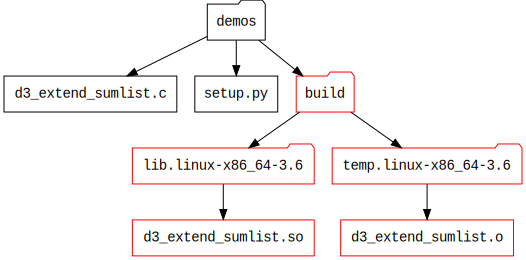

In [3]:
dotFigure("figures/g00_after_build.gv")

Again, red indicates files and directories added by ``distutils`` if necessary during the build.

Notice that the ``lib`` directory name now takes account of the build architecture and the Python version (i.e. ``Python.h`` and Python library) we're compiling for. Everything else in the distribution process: ``install``, ``sdist``, ``bdist*`` work as before, copying the "``*.so``" file(s) into their install destination (e.g. ``/usr/local/lib/python``*whatever*) or a ``dist`` subdirectory for subsequent packaging.

Since ``setup.py`` is included in the source ("``sdist``") distribution, anybody
who installs it and runs "``python3 setup.py build``" or "``python3 setup.py install``" on that platform will build or install a "``*.so``" module ready for their platform, regardless of OS. This is how Python allows for portability of compiled extensions.

The ``build/temp.*`` directory is there for debugging and will go away if you run: 

In [ ]:
%%sh
cd demos
python3 setup.py clean

### Automatic API Construction With ``swig``

Creating a "``*.so``" file "by hand" like this is a good strategy when you've got just a few C functions to access, but let's suppose you had a larger body of code you didn't want to convert by hand, especially one that might be changing. In that case, there's *swig*: Simplified Wrapper and Interface Generator.

#### A Simple ``swig`` Example

Let's start with a simple example.

Start with a header file declaring three functions we'd like to call from Python:

In [ ]:
%%file demos/d4_swig_3funcs.h
extern int fact(int n);
extern int my_mod(int x, int y);
extern char *get_time(void);

Here's the C file that implements these functions:

In [ ]:
%%file demos/d4_swig_3funcs.c
#include <time.h>
#include "d4_swig_3funcs.h"

int fact(int n)
{
    if (n <= 1)
        return 1;
    else
        return n*fact(n-1);
}

int my_mod(int n, int m)
{
    return (n % m);
}

char *get_time(void)
{
    long ltime;
    time(&ltime);
    return ctime(&ltime);
}

*swig* works with an interface specification file, usually with a "``*.i``" extension, that has prototypes of all the functions you wish to export to Python. If you want to import everything in the header file, you can "``%include ``" (note the "``%``") it.

In [ ]:
%%file demos/d4_swig_3funcs.i
%module d4_swig_3funcs

%{
/* include required header files for the wrapper here */
#include "d4_swig_3funcs.h"
%}

/*
 * Note the "%" prefix. The "*.i" file is not a header file: "#" won't
 * work here. If you don't want to export every declaration in the
 * header file, include only those you want here.
 */
%include "d4_swig_3funcs.h"

So we start out with a directory containing these three files:

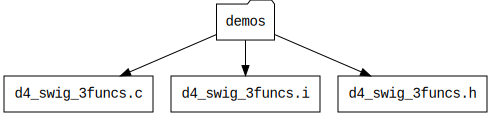

In [6]:
dotFigure("figures/g01_initial_swig.gv")

We compile the C source to an object file as usual:

In [ ]:
!cd demos; make clean; make d4_swig_3funcs.o

But instead of converting the "``*.o``" file to a "``*.so``" file as for an extension, we run *swig*:

*You'll need to install *swig* to do this.*

In [ ]:
%%sh
cd demos
swig -python -module d4_swig_3funcs d4_swig_3funcs.i

The directory now looks like this:

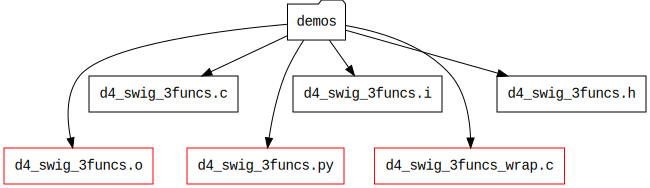

In [7]:
dotFigure("figures/g02_after_swig.gv")

Next, we compile the (pretty big, but so what?) C wrapper file:

In [ ]:
%%sh
cd demos
make d4_swig_3funcs_wrap.o OSNAME=LINUX

*Then* we create the "``*.so``" file with both the original object *and* the compiled "``*_wrap.o``" file, but we prefix the name with "``_``" because we won't import it directly. The "``*.py``" file is expecting the "``_``" and will do that.

In [ ]:
%%sh
cd demos
ld -shared d4_swig_3funcs.o d4_swig_3funcs_wrap.o -o _d4_swig_3funcs.so

And we can now access the module's functions in the usual way:

In [ ]:
%%sh
cd demos
python3 <<EOF
import d4_swig_3funcs
print(repr(d4_swig_3funcs.get_time()))
print(d4_swig_3funcs.my_mod(7, 5))
print(d4_swig_3funcs.fact(10))
EOF

Interesting sidelight: If you didn't have the source, only object ("``*.so``" or "``*.o``") and header files, you could still create a "``*.i``", run *swig* on it, compile the "``*_wrap.c``", and link the result with the object files to get a functioning API for code.

In short, *swig* does not require the source code. You could wrap *somebody else's* object and header files and access them from Python. Sneaky!

### Accessing C Code Directly With ``ctypes``

Suppose we just want to access some existing compiled C code without building a whole API or creating a Python module to access it. That's what ``ctypes`` is for.

#### Accessing Functions

Let's start with some code that has no knowledge that it's going to be accessed from Python: 

In [ ]:
%%file demos/d5_ctypes_simple.c
/*
 * arbitrary C code (adapted from from ctypes documentation)
 *
 * Note: No special Python #includes
 */

#include <time.h>

int fact(int n) {
// computes n!
    if (n <= 1)
        return 1;
    else
        return n * fact(n-1);
}

char *get_time(void) {
// returns a char * (C string)
    long ltime;
    time(&ltime);
    return ctime(&ltime);
}

int my_mod(int n, int m) {
// returns n mod m
    return (n % m);
}

Just compile it as usual and create a shared library with it:

In [ ]:
%%sh
cd demos
cc -c -g -shared -Wall -Wstrict-prototypes -fPIC d5_ctypes_simple.c
ld -shared d5_ctypes_simple.o -o d5_ctypes_simple.so

This is just a normal "``*.so``" file, so we can do this with any shared object.

In [ ]:
%%sh
cd demos
python3 <<EOF
from ctypes import CDLL, c_char_p, c_longlong
# note: You need to specify a directory, even if it's ".".
d5_ctypes_simple = CDLL("./d5_ctypes_simple.so") # equivalent to "import"

time = d5_ctypes_simple.get_time()
print("using default get_time() return type")
print("      get_time() return: {!r}".format(time))
print("  isinstance(time, int): {}".format(isinstance(time, int)))
print()

print("after coercing get_time return type to \"c_char_p\" (char *)")
d5_ctypes_simple.get_time.restype = c_char_p
time = d5_ctypes_simple.get_time()
print("      get_time() return: {}".format(time))
print("  isinstance(time, int):", isinstance(time, int))
print("isinstance(time, bytes):", isinstance(time, bytes))
print()

d5_ctypes_simple.restype = c_longlong
for i in range(0,15):
    n = d5_ctypes_simple.fact(i)
    print("{:>2} factorial is {:12}".format(i, n))
EOF

Check that last value!

``ctypes`` exports the ``cdll`` object, which is a "library loader". On Windows,
there are also ``windll`` and ``oledll`` objects, which do similar things for Windows and OLE DLL files.

The ``CDLL()`` call above is actually instancing the ``CDLL`` class. It's the same as ``cdll.LoadLibrary()``.

#### Accessing Global Data

To access (global) data from C code, start again with C source (or an "``*.so``" file whose contents you know the names and C types of):

In [ ]:
%%file demos/d6_ctypes_data.c
/*
 *  Initialize some C global variables.
 */
float f = 42.0;
double d = -19.53;
int i = -34;
char *s = "spam";

Then compile and link it into a "``*.so``" file:

In [ ]:
%%sh
cd demos
cc -c -g -shared -Wall -Wstrict-prototypes d6_ctypes_data.c
ld -shared d6_ctypes_data.o -o d6_ctypes_data.so

You can then access the data with ``ctypes`` as follows:

In [ ]:
%%sh
cd demos
python3 <<EOF
from ctypes import CDLL, c_float, c_double, c_int, c_char_p
data = CDLL("./d6_ctypes_data.so")

f = c_float.in_dll(data, "f")
print("{:>24}: {}".format(str(f), f.value))

d = c_double.in_dll(data, "d")
print("{:>24}: {}".format(str(d), d.value))

i = c_int.in_dll(data, "i")
print("{:>24}: {}".format(str(i), i.value))

s = c_char_p.in_dll(data, "s")
print("{:>24}: {}".format(str(s), s.value))
EOF